In [20]:
from __future__ import absolute_import, division, print_function
import glob
import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import pdb
import getpass
from scipy import stats
from sklearn import linear_model
from numpy import linalg as LA
import numpy.random as npr
from sklearn.decomposition import PCA

ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
elif ui == 'lndrisco':
    p = '/home/users/lndrisco'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

PATH_YANGNET = os.path.join(p,'code/multitask-nets',net)

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import get_T_inds, plot_N, plot_FP, name_best_ckpt, generate_Beta_epoch, make_h_combined, same_stim_trial

PATH_TO_RECURRENT_WHISPERER = p+'/code/recurrent-whisperer'#'/home/laura/code/recurrent-whisperer'#
sys.path.insert(0, PATH_TO_RECURRENT_WHISPERER)
from RecurrentWhisperer import RecurrentWhisperer

PATH_TO_FIXED_POINT_FINDER = p+'/code/fixed-point-finder' #'/home/laura/code/fixed-point-finder-experimental'#
sys.path.insert(0, PATH_TO_FIXED_POINT_FINDER)
from FixedPointFinder import FixedPointFinder

In [21]:
def comp_eig_decomp(Ms, sort_by='real',
                                     do_compute_lefts=True):
  """Compute the eigenvalues of the matrix M. No assumptions are made on M.

  Arguments: 
    M: 3D np.array nmatrices x dim x dim matrix
    do_compute_lefts: Compute the left eigenvectors? Requires a pseudo-inverse 
      call.

  Returns: 
    list of dictionaries with eigenvalues components: sorted 
      eigenvalues, sorted right eigenvectors, and sored left eigenvectors 
      (as column vectors).
  """
  if sort_by == 'magnitude':
    sort_fun = np.abs
  elif sort_by == 'real':
    sort_fun = np.real
  else:
    assert False, "Not implemented yet."      
  
  decomps = []
  L = None  
  for M in Ms:
    evals, R = LA.eig(M)    
    indices = np.flipud(np.argsort(sort_fun(evals)))
    if do_compute_lefts:
      L = LA.pinv(R).T  # as columns      
      L = L[:, indices]
    decomps.append({'evals' : evals[indices], 'R' : R[:, indices],  'L' : L})
  
  return decomps

In [58]:
def plot_FP(X, D, eig_decomps, cr):
    """Plot activity is some 2D space.

        Args:
            X: Fixed points in #Fps x Neurons
            D: Neurons x 2 plotting dims
    
        """
    S = np.shape(X)[0]
    lf = .10
    rf = .10
    
    for s in range(S):
        c = 'k'
        
        X_trial = np.dot(X[s,:],D.T)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']>1)+1
        if len(n_arg)>0:
            for arg in range(np.max(n_arg)):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2],'k',alpha = .5,linewidth = .5)
        
        n_arg = np.argwhere(eig_decomps[s]['evals']<.3)
        if len(n_arg)>0:
            for arg in range(np.min(n_arg),len(eig_decomps[s]['evals'])):
                rdots = np.dot(np.real(eig_decomps[s]['R'][:, arg]).T,D.T)
                ldots = np.dot(np.real(eig_decomps[s]['L'][:, arg]).T,D.T)
                overlap = np.dot(rdots,ldots.T)
                r = np.concatenate((X_trial - rf*overlap*rdots, X_trial + rf*overlap*rdots),0)
                plt.plot(r[0:4:2],r[1:4:2],'b',alpha = .5,linewidth = .5)
            
        plt.plot(X_trial[0],X_trial[1],'o',c = cr, markersize = 2)
        plt.plot(X_trial[0],X_trial[1],'.',c = 'k', markersize = 2)

def make_axes(model_dir_all,ckpt_n_dir,rule_master,epoch,ind = -1):

    model = Model(model_dir_all)
    with tf.Session() as sess:

        model.saver.restore(sess,ckpt_n_dir)
        # get all connection weights and biases as tensorflow variables
        var_list = model.var_list
        # evaluate the parameters after training
        params = [sess.run(var) for var in var_list]
        # get hparams
        hparams = model.hp
        trial_master = generate_trials(rule_master, hparams, mode = 'test', batch_size = 400, noise_on=False, delay_fac =1)
        feed_dict = tools.gen_feed_dict(model, trial_master, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_trials, n_neuron)

    Beta_epoch = generate_Beta_epoch(h_tf,trial_master,ind = ind)
    X_pca = Beta_epoch[epoch]    
    D = np.concatenate((np.expand_dims(X_pca[:,0],axis=1),np.expand_dims(X_pca[:,1],axis=1)),axis = 1)
    return D

In [30]:
def plot_fp_struct_multicolor(m,ckpt_n_dir,tasks,trial_set,r,D,fp_epoch,axes_epoch,do_plot_FP,t_num = 0,qlim = .000001,color_label = 'stim1',alpha_color = 'white'):
    cmap=plt.get_cmap('rainbow')
    plt.rcParams.update({'font.size': 18})

    ## plot w test set of trials
    model = Model(m)
    with tf.Session() as sess:
        model.saver.restore(sess,ckpt_n_dir)
        hparams = model.hp

        for rule_ind in tasks:
            rule = rules_dict['all'][rule_ind]
            trial = generate_trials(rule, hparams, mode='test', batch_size = np.max(trial_set), noise_on=True, delay_fac =1)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

            T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing

            fldr = os.path.join(m,'golub_fixed_pts',rule,fp_epoch+'*')
            f_list = [f for f in glob.glob(fldr)]

            T,S,N = np.shape(h_tf)
            
            stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
            stim2_locs = np.min(trial.stim_locs[:,[1,3]],axis=1)
            y_loc = trial.y_loc[-1,:]
            
            if color_label == 'stim1' or color_label == 'delay1':
                c_inds = stim1_locs
            elif color_label == 'stim2' or color_label == 'delay2':
                c_inds = stim2_locs
            else:
                c_inds = y_loc
            
            if do_plot_FP==0:
                for s in range(0,S,int(S/100)):
                    c = cmap(c_inds[s]/(2*np.pi))
                    X_trial = np.dot(h_tf[T_inds,s,:],D)
                    plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1)
                    if alpha_color == 'black':
                        plt.plot(X_trial[0,0],X_trial[0,1],'^',c = 'k', alpha = .3, linewidth = 1)
                        plt.plot(X_trial[:,0],X_trial[:,1],'-',c = 'k', alpha = .3, linewidth = 1)
                    
                    if s==0:
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3,label = rule)
                    else:
                        plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3)
                    
            elif do_plot_FP==1:
                
                c = 'gray'
                for s in range(0,S,int(S/20)):
                    X_trial = np.dot(h_tf[T_inds,s,:],D)
                    plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1)
                    plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1)
                    plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3)
                        
                s = t_num
                filename = os.path.join(m,'golub_fixed_pts',rule,fp_epoch+'_'+str(t_num)+'.npz')

                if os.path.exists(filename):
                    print(filename)
                else:
                    filename = os.path.join(m,'golub_fixed_pts',rule,fp_epoch+'_'+str(0)+'.npz')
                    
                fp_struct = np.load(filename)
                c = cmap(c_inds[s]/(2*np.pi))

                X_trial = np.dot(h_tf[T_inds,s,:],D)
                plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 2)
                plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 2)
                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .5,label = rule)

                fp_logic = fp_struct['qstar']< qlim
                eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_logic,:,:])
                sorted_fps = fp_struct['xstar'][fp_logic,:]
                plot_FP(sorted_fps, D.T, eig_decomps, c)
                
            elif do_plot_FP==2:
                
                for s in range(0,S,int(S/20)):
                    filename = f_list[s]

                    if os.path.exists(filename):
                        print(filename)
                        fp_struct = np.load(filename)
                        c = cmap(c_inds[s]/(2*np.pi))
                        if fp_struct['trial_num']%4==0:

                            X_trial = np.dot(h_tf[T_inds,fp_struct['trial_num'],:],D)
                            plt.plot(X_trial[0,0],X_trial[0,1],'^',c = c, linewidth = 1)
                            plt.plot(X_trial[:,0],X_trial[:,1],'-',c = c, linewidth = 1)
                            if s==0:
                                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3,label = rule)
                            else:
                                plt.plot(X_trial[-1,0],X_trial[-1,1],'o',c = c, linewidth = .3)

                            fp_logic = fp_struct['qstar']< qlim
                            eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_logic,:,:])
                            sorted_fps = fp_struct['xstar'][fp_logic,:]
                            plot_FP(sorted_fps, D.T, eig_decomps, c)

            plt.xlabel(r + ' Beta_' + axes_epoch + ' cos@')
            plt.ylabel(r + ' Beta_' + axes_epoch + ' sin@') 
            plt.title(rule + ' ' + fp_epoch+' activity')
            
def plot_in_time(rule,trial,h_tf,axes_epoch,color_label,trial_subset,D):
    cmap=plt.get_cmap('rainbow')
    plt.rcParams.update({'font.size': 18})

    stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
    stim2_locs = np.min(trial.stim_locs[:,[1,3]],axis=1)
    stim1_strength = np.min(trial.stim_strength[:,[0,2]],axis=1)
    stim2_strength = np.min(trial.stim_strength[:,[1,3]],axis=1)
    y_loc = trial.y_loc[-1,:]

    if color_label == 'stim1' or color_label == 'delay1':
        c_inds = stim1_locs
    elif color_label == 'stim2' or color_label == 'delay2':
        c_inds = stim2_locs
    elif color_label == 'stim1_strength':
        c_inds = stim1_strength
    elif color_label == 'stim2_strength':
        c_inds = stim2_strength
    else:
        c_inds = y_loc

    fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

    for s in up:
        c = cmap(c_inds[s]/(np.max(c_inds)))
        X_trial = np.dot(h_tf[:,s,:],D)
        plt.subplot(2,1,1)
        plt.plot(X_trial[:,0],'-',c = c, linewidth = 2)
        plt.subplot(2,1,2)
        plt.plot(X_trial[:,1],'-',c = c, linewidth = 2)

    plt.subplot(2,1,1)
    for e in trial.epochs.keys():
        plt.text(np.max([trial.epochs[e][0],0])+1,-.3,e,)
        if trial.epochs[e][1]>0:
            plt.plot([trial.epochs[e][1],trial.epochs[e][1]],[-.4,.4],'k',linewidth = .2)
    plt.title(rule + ' color label : ' + color_label)
    plt.xlabel('time in trial')
    plt.ylabel(axes_epoch + ' cosine angle')

    plt.subplot(2,1,2)
    for e in trial.epochs.keys():
        plt.text(np.max([trial.epochs[e][0],0])+1,-.3,e)
        if trial.epochs[e][1]>0:
            plt.plot([trial.epochs[e][1],trial.epochs[e][1]],[-.4,.4],'-k',linewidth = .2)

    plt.title(rule + ' color label : ' + color_label)
    plt.xlabel('time in trial')
    plt.ylabel(axes_epoch + ' sine angle')

In [24]:
def plot_fp_struct_eigenspec(rule,fp_epoch,t_num=0,do_nfp=1):
    
    T,S,N = np.shape(h_tf)
    filename = os.path.join(model_dir_all,'golub_fixed_pts',rule,fp_epoch+'_'+str(t_num)+'.npz')

    if os.path.exists(filename):
        fp_struct = np.load(filename)
        fp_logic = fp_struct['qstar']<.0000001
        eig_decomps = comp_eig_decomp(fp_struct['J_xstar'][fp_logic,:,:])
        
        plt.subplot()
        
        if do_nfp == 0:
            plt.plot(eig_decomps[nfp]['evals'].real,eig_decomps[nfp]['evals'].imag,'.k')
            plt.title('max eigenval : ' +str(np.max(eig_decomps[nfp]['evals'].real)))
        else:
            for nfp in range(len(eig_decomps)):
                plt.plot(eig_decomps[nfp]['evals'].real,eig_decomps[nfp]['evals'].imag,alpha = .1)
                plt.title('max eigenval : ' +str(np.max(eig_decomps[nfp]['evals'].real)),alpha = .1)

In [25]:
net = 'stepnet'
tasks = [0]
rule = rules_dict['all'][tasks[0]]
fp_epoch = 'stim1'
model_n = 0
dir_specific_all = 'crystals/softplus/l2h00001'#'crystals/softplus/l2h00001'#'stepnet/crystals/softplus/'#grad_norm_both/'#'lowD/combos'#'stepnet/lowD/tanh'#'lowD/grad_norm_l2001' #' #'lowD/armnet_noreg'#lowD/combos' ##grad_norm_l2h000001' /Documents/data/rnn/multitask/varGo/lowD/most/
model_dir_all = os.path.join(p,'data/rnn/multitask/',dir_specific_all,str(model_n))
ckpt_n = name_best_ckpt(model_dir_all,rule)
ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

In [26]:
## plot w test set of trials
model = Model(model_dir_all)
with tf.Session() as sess:
    model.saver.restore(sess,ckpt_n_dir)
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', batch_size = 100, noise_on=True, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

T,S,N = np.shape(h_tf)
trial_set = range(0,S,10)
epoch_set = trial.epochs.keys()
print(trial.epochs.keys())

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
['stim1', 'go1', 'fix1']


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

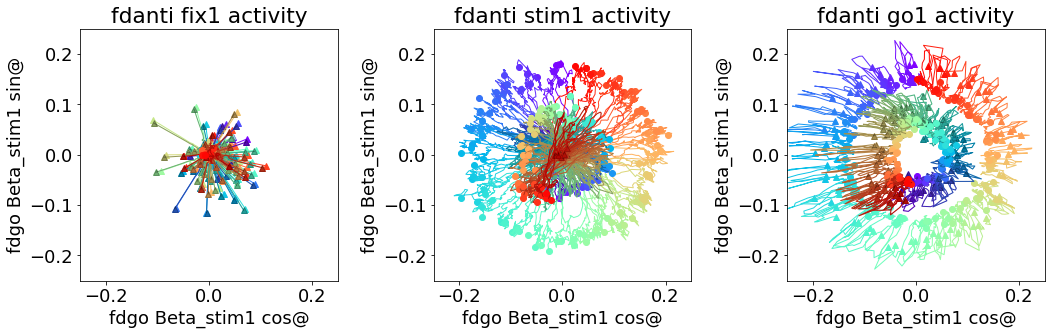

In [31]:
epoch_order = [2,0,1]
axes_epoch = 'stim1'

fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D_stim = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[0],trial_set,rule,D_stim,fp_epoch,axes_epoch,do_plot_FP=0)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[3],trial_set,rule,D_stim,fp_epoch,axes_epoch,do_plot_FP=0,alpha_color = 'black')
    plt.ylim((-.25,.25))
    plt.xlim((-.25,.25))
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

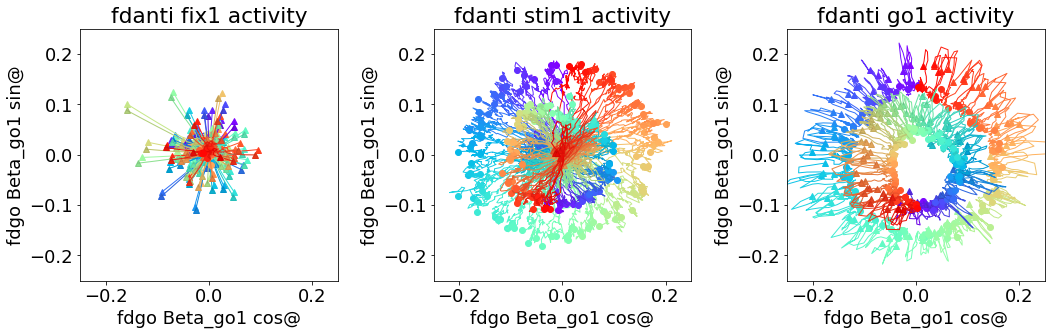

In [29]:
epoch_order = [2,0,1]
axes_epoch = 'go1'

fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D_go = make_axes(model_dir_all,ckpt_n_dir,rule,axes_epoch)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[0],trial_set,rule,D_go,fp_epoch,axes_epoch,do_plot_FP=0)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[3],trial_set,rule,D_go,fp_epoch,axes_epoch,do_plot_FP=0,alpha_color = 'black')
    plt.ylim((-.25,.25))
    plt.xlim((-.25,.25))
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = rule+'_'+axes_epoch+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [33]:
print(rule,tasks)

fdgo [0]


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/f

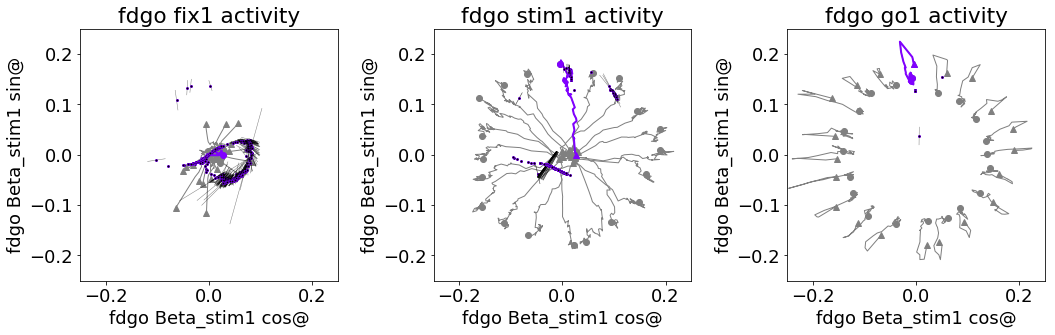

In [38]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 0
rule_ind = 0
rule = rules_dict['all'][rule_ind]
axes_rule = 'fdgo'

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D = make_axes(model_dir_all,ckpt_n_dir,axes_rule,axes_epoch)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[rule_ind],trial_set,axes_rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,qlim = .000001)
    plt.ylim((-.25,.25))
    plt.xlim((-.25,.25))
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = axes_rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/f

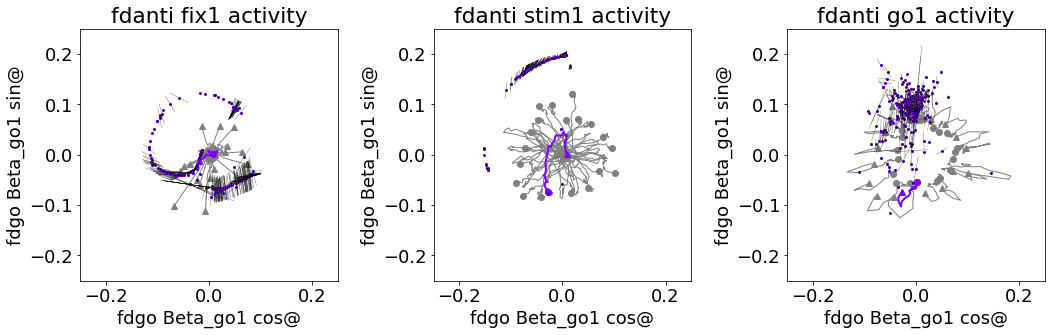

In [60]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 0
rule_ind = 3
rule = rules_dict['all'][rule_ind]
axes_rule = 'fdgo'
qlim = .001

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D = make_axes(model_dir_all,ckpt_n_dir,axes_rule,axes_epoch,ind = 3)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[rule_ind],trial_set,axes_rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,qlim = qlim)
    plt.ylim((-.25,.25))
    plt.xlim((-.25,.25))
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = axes_rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [ ]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 0
rule_ind = 3
rule = rules_dict['all'][rule_ind]
axes_rule = 'fdgo'
qlim = .001

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D = make_axes(model_dir_all,ckpt_n_dir,axes_rule,axes_epoch,ind = 3)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[rule_ind],trial_set,axes_rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,qlim = qlim)
    plt.ylim((-.25,.25))
    plt.xlim((-.25,.25))
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = axes_rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/f

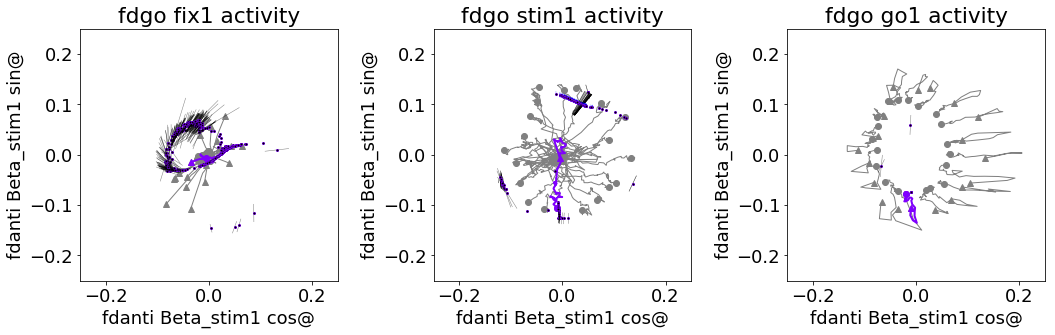

In [40]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 0
rule_ind = 0
rule = rules_dict['all'][rule_ind]
axes_rule = 'fdanti'

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D = make_axes(model_dir_all,ckpt_n_dir,axes_rule,axes_epoch)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[rule_ind],trial_set,axes_rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,qlim = .000001)
    plt.ylim((-.25,.25))
    plt.xlim((-.25,.25))
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = axes_rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/f

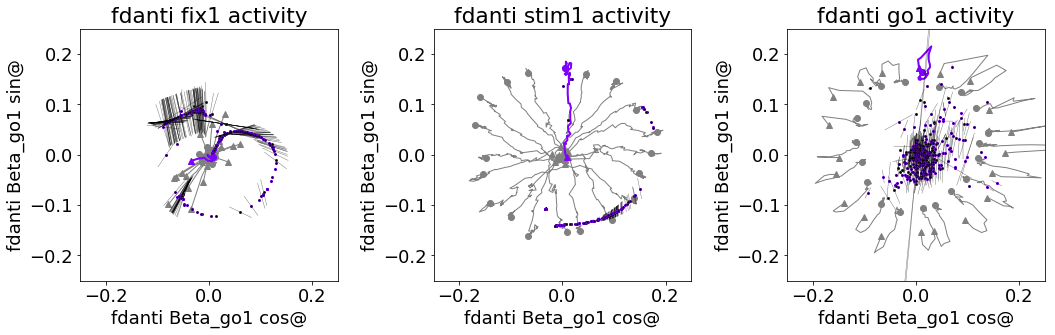

In [59]:
fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')
t_num = 0
rule_ind = 3
rule = rules_dict['all'][rule_ind]
axes_rule = 'fdanti'
qlim = .01

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    D = make_axes(model_dir_all,ckpt_n_dir,axes_rule,axes_epoch,ind = 3)
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[rule_ind],trial_set,axes_rule,D,fp_epoch,axes_epoch,do_plot_FP=1,t_num = t_num,qlim = qlim)
    plt.ylim((-.25,.25))
    plt.xlim((-.25,.25))
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = axes_rule+'_'+axes_epoch+'_axes_Fp_one_trial_'+str(t_num)+'.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

In [11]:
from tools_lnd import get_model_params
w_in, b_in, w_out, b_out = get_model_params(model_dir_all,ckpt_n_dir)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

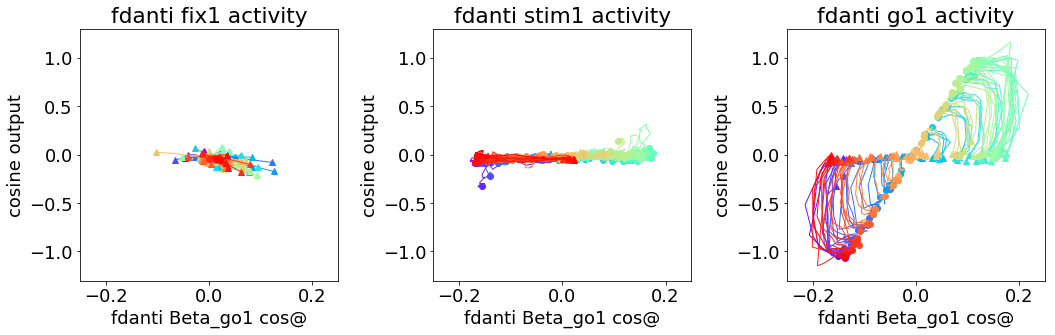

In [45]:
rule_ind = 3
rule = rules_dict['all'][rule_ind]
axes_rule = 'fdanti'
D_stim = make_axes(model_dir_all,ckpt_n_dir,axes_rule,axes_epoch)
D = np.concatenate((D_stim[:,1:2],w_out[:,2:3]),axis = 1)
epoch_order = [2,0,1]
axes_epoch = 'go1'
qlim = .00001

fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[rule_ind],trial_set,axes_rule,D,fp_epoch,axes_epoch,qlim = qlim,do_plot_FP=0)
    plt.ylabel('cosine output')
    plt.ylim((-1.3,1.3))
    plt.xlim((-.25,.25))
    
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = axes_rule+'_'+'output_axes'+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=flo

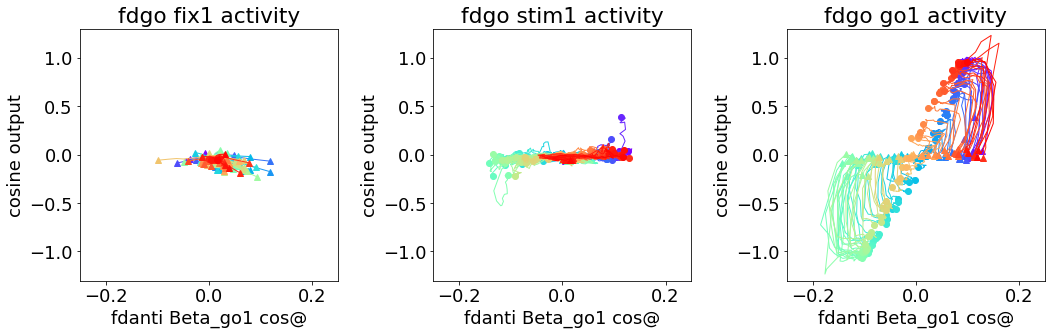

In [46]:
rule_ind = 0
rule = rules_dict['all'][rule_ind]
axes_rule = 'fdanti'
D_stim = make_axes(model_dir_all,ckpt_n_dir,axes_rule,axes_epoch)
D = np.concatenate((D_stim[:,1:2],w_out[:,2:3]),axis = 1)
epoch_order = [2,0,1]
axes_epoch = 'go1'

fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[rule_ind],trial_set,axes_rule,D,fp_epoch,axes_epoch,do_plot_FP=0)
    plt.ylabel('cosine output')
    plt.ylim((-1.3,1.3))
    plt.xlim((-.25,.25))
    
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = axes_rule+'_'+'output_axes'+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/f

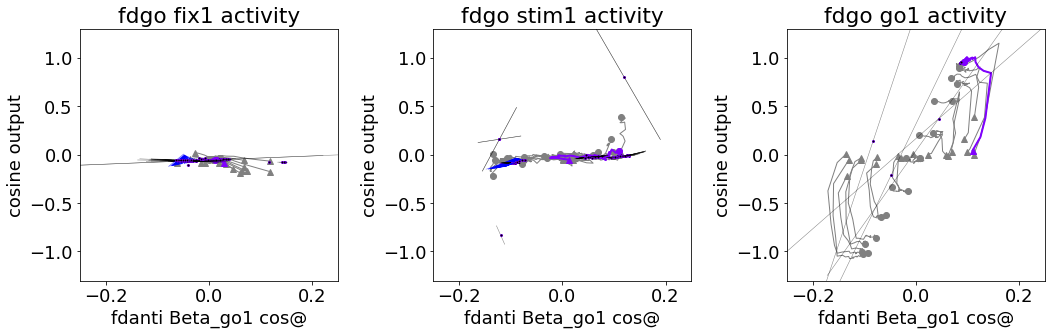

In [50]:
rule_ind = 3
rule = rules_dict['all'][rule_ind]
axes_rule = 'fdanti'
D_stim = make_axes(model_dir_all,ckpt_n_dir,axes_rule,axes_epoch)
D = np.concatenate((D_stim[:,1:2],w_out[:,2:3]),axis = 1)
epoch_order = [2,0,1]
axes_epoch = 'go1'
qlim = .0001

fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[rule_ind],trial_set,axes_rule,D,fp_epoch,axes_epoch,qlim = qlim,do_plot_FP=1)
    plt.ylabel('cosine output')
    plt.ylim((-1.3,1.3))
    plt.xlim((-.25,.25))
    
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = axes_rule+'_'+'output_axes'+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/ckpts/model.ckpt-1207000
/Users/lauradriscoll/Documents/data/rnn/multitask/crystals/softplus/l2h00001/0/golub_fixed_pts/f

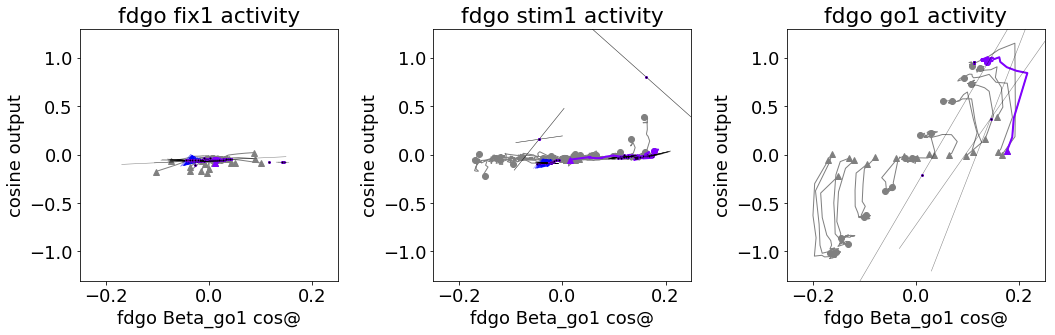

In [54]:
rule_ind = 0
rule = rules_dict['all'][rule_ind]
axes_rule = 'fdgo'
D_stim = make_axes(model_dir_all,ckpt_n_dir,axes_rule,axes_epoch)
D = np.concatenate((D_stim[:,1:2],w_out[:,2:3]),axis = 1)
epoch_order = [2,0,1]
axes_epoch = 'go1'
qlim = .000001

fig = plt.figure(figsize=(len(epoch_set)*5,5),tight_layout=True,facecolor='white')

for fp_epoch_ind in range(len(epoch_set)):
    fp_epoch = epoch_set[epoch_order[fp_epoch_ind]]
    plt.subplot(1,len(epoch_set),fp_epoch_ind+1)
    plot_fp_struct_multicolor(model_dir_all,ckpt_n_dir,[rule_ind],trial_set,axes_rule,D,fp_epoch,axes_epoch,qlim = qlim,do_plot_FP=1)
    plt.ylabel('cosine output')
    plt.ylim((-1.3,1.3))
    plt.xlim((-.25,.25))
    
    
figpath = os.path.join(model_dir_all,'tf_fixed_pt_figs',rule)
figname = axes_rule+'_'+'output_axes'+'_axes_Activity_all_trials.pdf'
if not os.path.exists(figpath):
    os.makedirs(figpath)
plt.savefig(os.path.join(figpath,figname))
plt.show()